In [1]:
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
import scipy.optimize as opt
from scipy.stats import chi2

First, define a gravitational potential.

In [2]:
pot = gp.MilkyWayPotential()

Select a star.

In [3]:
dict14 = {
    'ra': 161.0072805184, #degree
    'e_ra': 0.0001, #degree
    'dec': 6.1941762509, #degree
    'e_dec': 0.0001, #degree
    'dist': 102.66, #kpc
    'e_dist': 16.55, #kpc
    'pmra': -2.17, #mas/yr
    'e_pmra': 1.38, #mas/yr
    'pmdec': 2.28, #mas/yr
    'e_pmdec': 1.68, #mas/yr
    'rv': 537.30, #km/s
    'e_rv': 7.20, #km/s
    }

hvs14 = coord.SkyCoord(
    ra=dict14['ra'] * u.degree,
    dec=dict14['dec'] * u.degree,
    distance=dict14['dist'] * u.kpc,
    pm_ra_cosdec=dict14['pmra'] * (u.mas / u.yr),
    pm_dec=dict14['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict14['rv'] * (u.km / u.s),
    frame="icrs"
)

hvs14_GC = hvs14.transform_to(coord.Galactocentric)

Set initial conditions and specify time-stepping

In [4]:
hvs14_ics = gd.PhaseSpacePosition(pos=hvs14_GC.cartesian.xyz, vel=hvs14_GC.velocity.d_xyz)
hvs14_orbit1 = pot.integrate_orbit(hvs14_ics, dt=-0.1*u.Myr, n_steps=10000) # 1 Gyr
hvs14_orbit2 = pot.integrate_orbit(hvs14_ics, dt=-0.1*u.Myr, n_steps=5000) # 500 Myr
hvs14_orbit3 = pot.integrate_orbit(hvs14_ics, dt=-0.1*u.Myr, n_steps=1000) # 100 Myr

        Use name instead. [gala.dynamics.core]


Sample 100 clones from the uncertainties.

In [5]:
n_samples = 1000
ra_samples = np.random.normal(dict14['ra'], dict14['e_ra'], n_samples)
dec_samples = np.random.normal(dict14['dec'], dict14['e_dec'], n_samples)
dist_samples = np.random.normal(dict14['dist'], dict14['e_dist'], n_samples)
pmra_samples = np.random.normal(dict14['pmra'], dict14['e_pmra'], n_samples)
pmdec_samples = np.random.normal(dict14['pmdec'], dict14['e_pmdec'], n_samples)
rv_samples = np.random.normal(dict14['rv'], dict14['e_rv'], n_samples)

ics_list = []
for ra, dec, dist, pmra, pmdec, rv in zip(ra_samples, dec_samples, dist_samples, pmra_samples, pmdec_samples, rv_samples):
    sc = coord.SkyCoord(ra=ra * u.degree,
                  dec=dec * u.degree,
                  distance=dist * u.kpc,
                  pm_ra_cosdec=pmra * (u.mas / u.yr),
                  pm_dec=pmdec * (u.mas / u.yr),
                  radial_velocity=rv * (u.km / u.s),
                  frame="icrs")
    gc = sc.transform_to(coord.Galactocentric)
    ics = gd.PhaseSpacePosition(pos=gc.cartesian.xyz, vel=gc.velocity.d_xyz)
    ics_list.append(ics)

Integrate all of the orbits

In [6]:
orbits1 = []
orbits2 = []
orbits3 = []
orbits1.append(hvs14_orbit1)
orbits2.append(hvs14_orbit2)
orbits3.append(hvs14_orbit3)
for ics in ics_list:
    orbit1 = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=10000)
    orbit2 = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=5000)
    orbit3 = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=1000)
    orbits1.append(orbit1)
    orbits2.append(orbit2)
    orbits3.append(orbit3)

Define plotting technique

In [7]:
def plot_ellipse(x_vals, y_vals, plane, time):
    pos = np.column_stack((x_vals, y_vals))
    mean = np.mean(pos, axis=0)
    cov = np.cov(pos, rowvar=False)

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.scatter(x_vals, y_vals, s=3, color='red', alpha=0.5)

    # Confidence levels: 1σ (68%), 2σ (95%), 3σ (99.7%)
    for nsig in [1, 2, 3]:
        width, height = 2 * nsig * np.sqrt(eigvals)
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                          edgecolor='blue', fc='None', lw=2, label=f"{nsig}σ")
        ax.add_patch(ellipse)

    ax.set_xlabel(f"{plane[0]} [kpc]")
    ax.set_ylabel(f"{plane[1]} [kpc]")
    ax.set_title(f"HVS14 Distribution in {time} ({plane})")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

Plot the final positions of the star after 1 Gyr

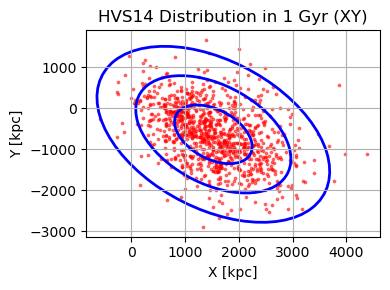

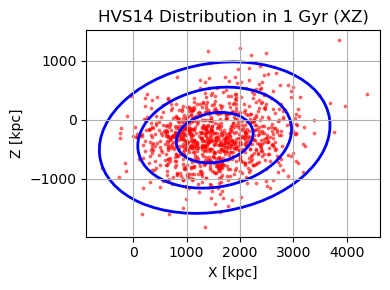

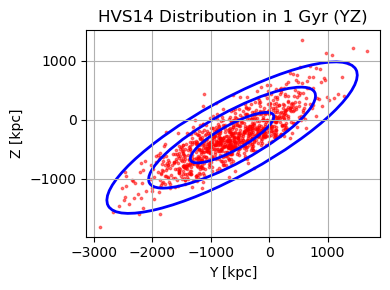

In [8]:
red_points = []

for i, orbit in enumerate(orbits1):
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    if i == 0:
        pass
    else:
        red_points.append(final_pos)

red_points = np.array(red_points)

x = red_points[:, 0]
y = red_points[:, 1]
z = red_points[:, 2]

plot_ellipse(x, y, "XY", "1 Gyr")
plot_ellipse(x, z, "XZ", "1 Gyr")
plot_ellipse(y, z, "YZ", "1 Gyr")

Plot the final positions of the star after 500 Myr

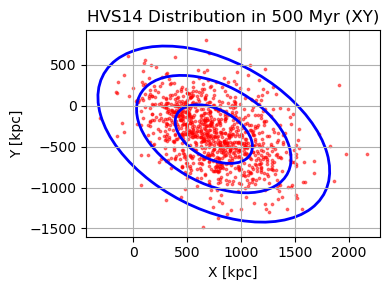

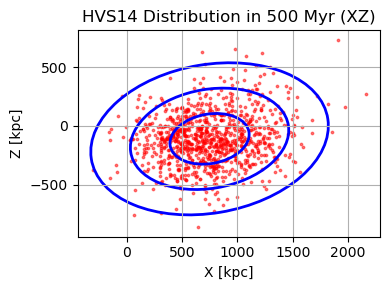

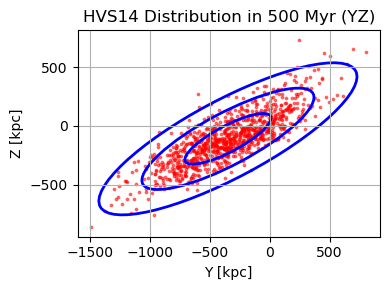

In [9]:
red_points = []

for i, orbit in enumerate(orbits2):
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    if i == 0:
        pass
    else:
        red_points.append(final_pos)

red_points = np.array(red_points)

x = red_points[:, 0]
y = red_points[:, 1]
z = red_points[:, 2]

plot_ellipse(x, y, "XY", "500 Myr")
plot_ellipse(x, z, "XZ", "500 Myr")
plot_ellipse(y, z, "YZ", "500 Myr")

Plot the final positions of the star after 100 Myr

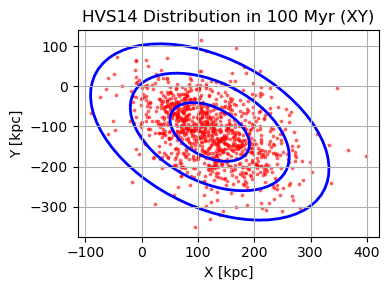

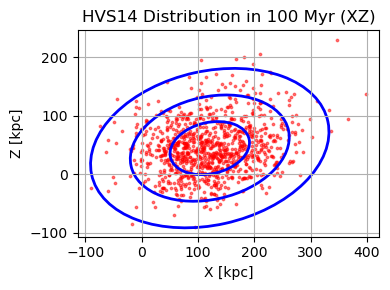

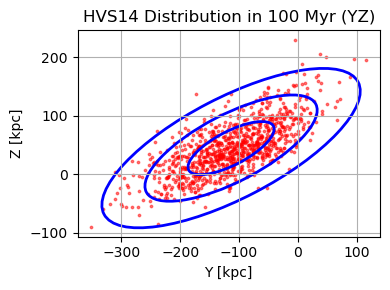

In [10]:
red_points = []

for i, orbit in enumerate(orbits3):
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    if i == 0:
        pass
    else:
        red_points.append(final_pos)

red_points = np.array(red_points)

x = red_points[:, 0]
y = red_points[:, 1]
z = red_points[:, 2]

plot_ellipse(x, y, "XY", "100 Myr")
plot_ellipse(x, z, "XZ", "100 Myr")
plot_ellipse(y, z, "YZ", "100 Myr")